In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os 
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from torch.nn.functional import cross_entropy
# import seaborn as sns

os.getcwd()

'/home/mgteus/workspace/neuro/transformers_andrej'

In [2]:
from attention_model import Head, get_batch1d, get_batch2d, RMSELoss, MultiHeadAttention, get_dataloader, PositionEncoding, Transformers, CustomRunsDataset, custom_dataloader

In [3]:
# path = {0:r'/home/mgteus/workspace/neuro/transformers_andrej/train_runs_15_100.gzip',
#         1:r'/home/mgteus/workspace/neuro/transformers_andrej/train_runs_15.gzip',
#         2:r'/home/mgteus/workspace/neuro/transformers_andrej/train_run.gzip'}
        
# df = pd.read_parquet(path[1], columns=['x_pos', 'y_pos'])
        

In [4]:
# from torchtune.modules import RotaryPositionalEmbeddings

In [5]:
np.random.random()

0.024419863196092684

In [6]:
CONTEXT_LEN = 128
BATCH_SIZE = 256
DROPOUT = 0.1
LEARNING_RATE = 1e-4
NUM_HEADS = 4
NUM_EPOCHS = 500
NUM_BLOCKS = 1
HEAD_SIZE = 16
HEAD_OUTPUT_DIM = 1
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
DEVICE, NUM_EPOCHS

('cuda', 500)

In [8]:
model = Transformers(
    num_blocks=NUM_BLOCKS,
    num_heads=NUM_HEADS,
    context_len=CONTEXT_LEN,
    batch_size=BATCH_SIZE,
    dropout=DROPOUT,
    head_output_dim=HEAD_OUTPUT_DIM,
    head_size=HEAD_SIZE
)

    # Model class must be defined somewhere
model.to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

In [9]:
# Criar o DataLoader
# dataloader = get_dataloader(split='train', batch_size=BATCH_SIZE, context_len=CONTEXT_LEN, device=DEVICE)

In [10]:
train_loss = []
batch_loss_list = []
test_loss = []
val_batch_loss_list = []
epoch = 0
mean_time = []

In [11]:
for epoch in range(int(NUM_EPOCHS)):
    model.train()
    epoch_loss = 0
    counter = 1
    dataset_train = CustomRunsDataset(split='train', device=DEVICE, context_len=CONTEXT_LEN, file=2, full=True)
    dataloader = custom_dataloader(dataset=dataset_train, batch_size=BATCH_SIZE, device=DEVICE)
    # dataloader = get_dataloader(split='train', batch_size=BATCH_SIZE, context_len=CONTEXT_LEN, device=DEVICE,)
    time_list = []
    for xb, yb in dataloader:
        # t1 = time.time()
        # xb = xb.to(DEVICE)
        # yb = yb.to(DEVICE)
        # print(xb.shape, yb.shape, counter)
        # xb, yb = get_batch2d(context_len=CONTEXT_LEN, batch_size=BATCH_SIZE, split='train', device=DEVICE)
        optimizer.zero_grad(set_to_none=True)
        predictions = model(xb)
        predictions = predictions.to(DEVICE)
        # print(predictions.shape)
        # loss = cross_entropy(predictions.view(BATCH_SIZE*CONTEXT_LEN, NUM_HEADS), yb.view(BATCH_SIZE*CONTEXT_LEN, NUM_HEADS))
        loss = RMSELoss(predictions.view(BATCH_SIZE*CONTEXT_LEN, NUM_HEADS), yb.view(BATCH_SIZE*CONTEXT_LEN, NUM_HEADS))
        # print(loss)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.cpu().detach().numpy()
        
        counter +=1
        # time_list.append(time.time() - t1)
    train_loss.append(epoch_loss / counter)
    # mean_time.append(np.mean(time_list))
    # if epoch%(NUM_EPOCHS/10)==0:
    #     print(f"iter. {epoch} - loss = {loss.item():4f}", datetime.now())
        # epoch+=1
    model.eval()
    val_epoch_loss = 0
    val_counter = 1
    with torch.no_grad():
        dataset_test = CustomRunsDataset(split='test', device=DEVICE, context_len=CONTEXT_LEN, file=2, full=True)
        val_dataloader = custom_dataloader(dataset=dataset_test, batch_size=BATCH_SIZE, device=DEVICE)
        for xbt, ybt in val_dataloader:
            # xbt = xbt.to(DEVICE)
            # ybt = ybt.to(DEVICE)
            val_predictions = model(xbt)
            # val_loss = cross_entropy(val_predictions.view(BATCH_SIZE*CONTEXT_LEN, NUM_HEADS), ybt.view(BATCH_SIZE*CONTEXT_LEN, NUM_HEADS))
            val_loss = RMSELoss(val_predictions.view(BATCH_SIZE*CONTEXT_LEN, NUM_HEADS), ybt.view(BATCH_SIZE*CONTEXT_LEN, NUM_HEADS))
            val_loss_cpu = val_loss.cpu().detach().numpy()
            val_epoch_loss += val_loss_cpu
            # val_batch_loss_list.append(val_loss_cpu)
            val_counter+=1
            
        test_loss.append(val_epoch_loss / val_counter)
    if epoch%(NUM_EPOCHS/10)==0:
        print(f"iter. {epoch:02d} - loss [train] = {(epoch_loss / counter):4f} - loss [test] = {(val_epoch_loss / val_counter):4f}", datetime.now())




            # print(f"iter. {epoch:02d} - loss  = {np.mean(test_loss):4f} [test]", datetime.now())
        # print(f"iter. {epoch:02d} - loss [train] = {np.mean(train_loss):4f} - last epoch loss = {(epoch_loss / counter):4f}", datetime.now())
        # print(f"iter. {epoch:02d} - loss [test] = {np.mean(test_loss):4f} - last epoch loss = {(val_epoch_loss / val_counter):4f}", datetime.now())



RuntimeError: The size of tensor a (2) must match the size of tensor b (4) at non-singleton dimension 2

In [12]:
loss.cpu().detach().numpy()

array(0.00744623, dtype=float32)

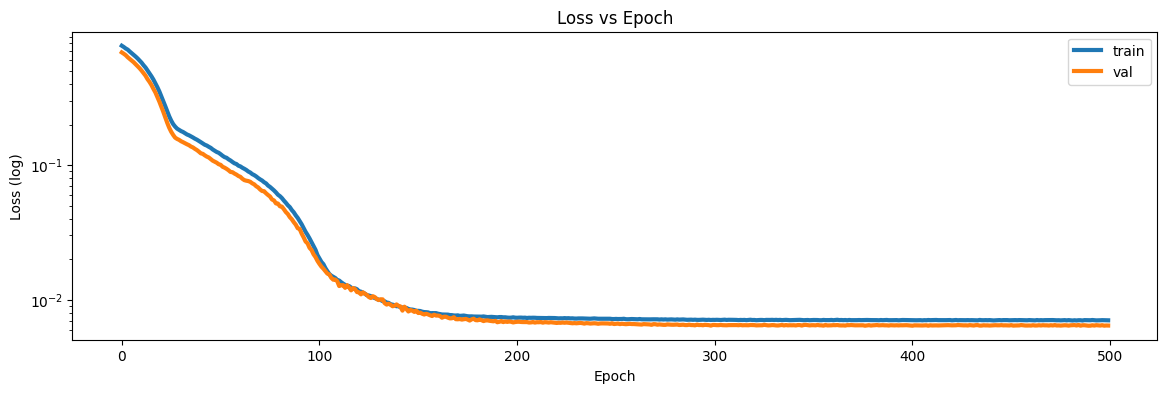

In [13]:
fig, ax = plt.subplots(figsize=(14,4))
plt.plot(train_loss, label='train', lw=3)
plt.plot(test_loss, label='val', lw=3)
plt.yscale('log')
plt.title('Loss vs Epoch')
plt.ylabel('Loss (log)')
plt.xlabel('Epoch')
plt.legend()
plt.show()

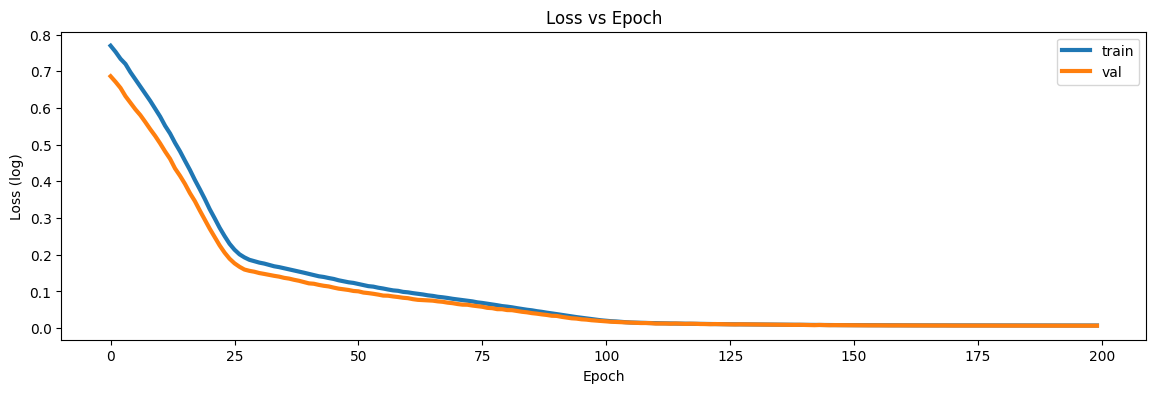

In [14]:
fig, ax = plt.subplots(figsize=(14,4))
plt.plot(train_loss[:200], label='train', lw=3)
plt.plot(test_loss[:200], label='val', lw=3)
# plt.yscale('log')
plt.title('Loss vs Epoch')
plt.ylabel('Loss (log)')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [15]:
epoch_loss / counter

0.007032911342225577

In [32]:
val_epoch_loss / val_counter

0.006585916131734848

In [16]:
np.std(train_loss)

0.12009683509676237

In [13]:
dataset_test = CustomRunsDataset(split='test', device=DEVICE, context_len=CONTEXT_LEN, file=2, full=True)
val_dataloader = custom_dataloader(dataset=dataset_test, batch_size=BATCH_SIZE, device=DEVICE)

In [14]:
for txb, tyb in val_dataloader:
    break

In [15]:
txb.shape, tyb.shape

(torch.Size([256, 128, 2]), torch.Size([256, 128, 2]))

In [16]:
tpredb = model(txb[:30, :, :])

In [17]:
txb[:30, :, :].shape

torch.Size([30, 128, 2])

In [22]:
# model.to(DEVICE)

In [18]:
tpred = model(txb[:30, :, :]).cpu().detach().numpy()
ty = tyb.cpu().detach().numpy()
tx = txb.cpu().detach().numpy()
tpred.shape, ty.shape, tx.shape

((30, 128, 2), (256, 128, 2), (256, 128, 2))

In [19]:
tx[0, 0:2, :]

array([[0.66577697, 0.8042242 ],
       [0.6745299 , 0.790452  ]], dtype=float32)

In [20]:
tpred[0, 0:2, :]

array([[0.6742872, 0.799354 ],
       [0.6736777, 0.7904508]], dtype=float32)

In [21]:
ty[0, 0:2, :]

array([[0.6745299 , 0.790452  ],
       [0.6817389 , 0.78131145]], dtype=float32)

In [27]:
# tpred[0, :,:]/

In [22]:
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

model size: 0.191MB


In [23]:
for i in range(1,4):
    print(model(txb[0:1,0:i,:])[0,-1,:].cpu().detach().numpy())

[2.892931e-03 7.371977e-05]
[0.00279141 0.00012156]
[0.00269995 0.0001647 ]


In [30]:
txb[0:1,0:i,:].shape

torch.Size([1, 3, 2])

In [24]:
model(txb[0:1,0:256,:])[0,-1,:].cpu().detach().numpy()

array([0.8179079, 0.33912  ], dtype=float32)

In [25]:
CONTEXT_LEN//16

8

In [27]:
model_prediction = model(txb[0:1,:,:]).cpu().detach().numpy()
model_prediction.shape

(1, 128, 2)

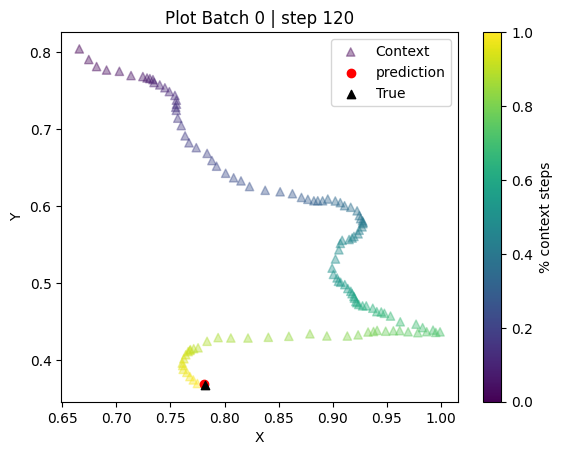

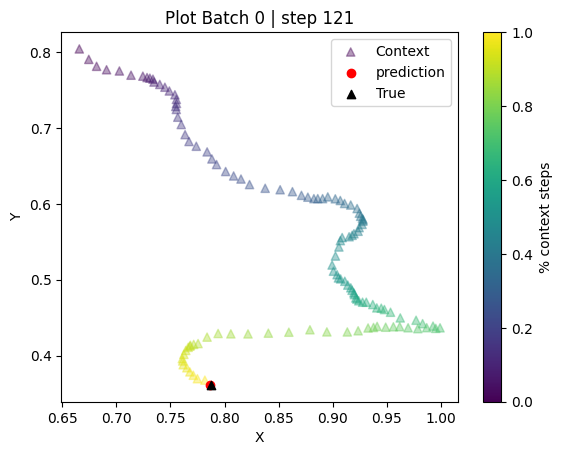

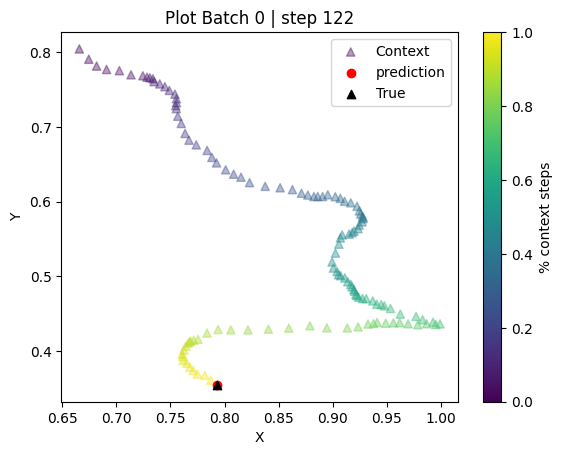

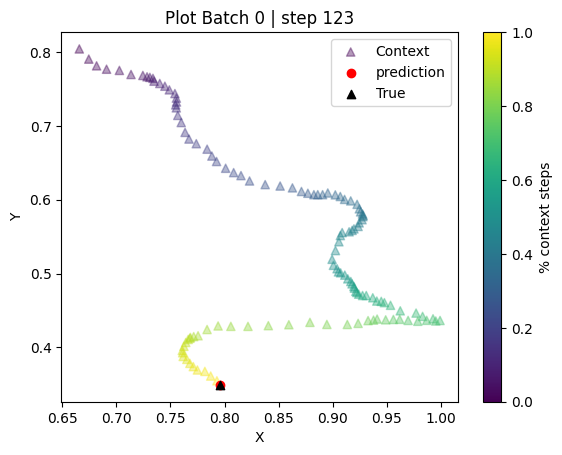

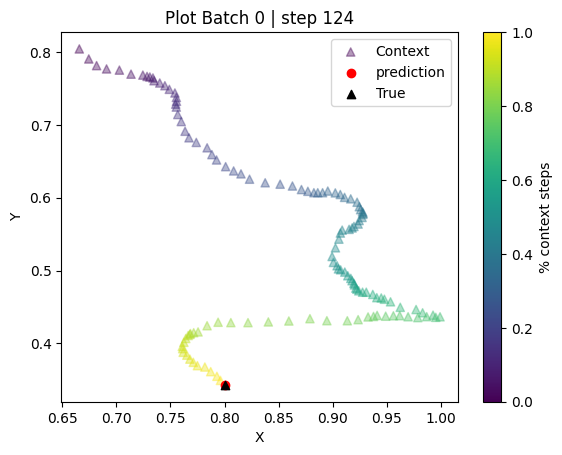

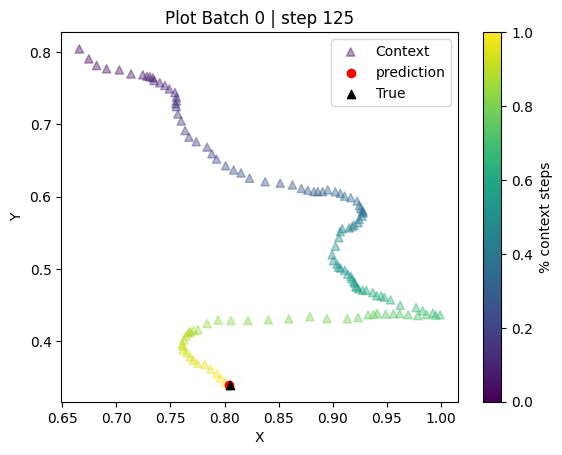

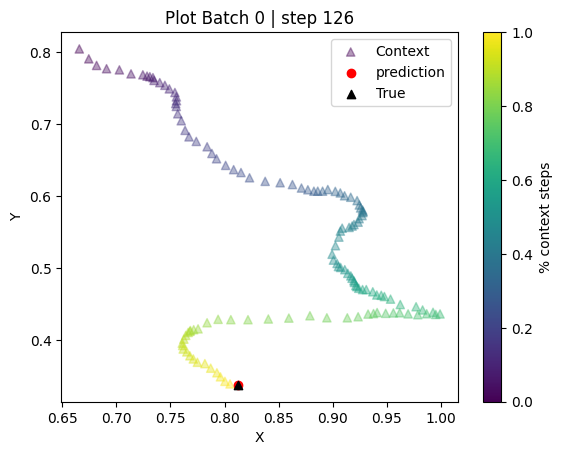

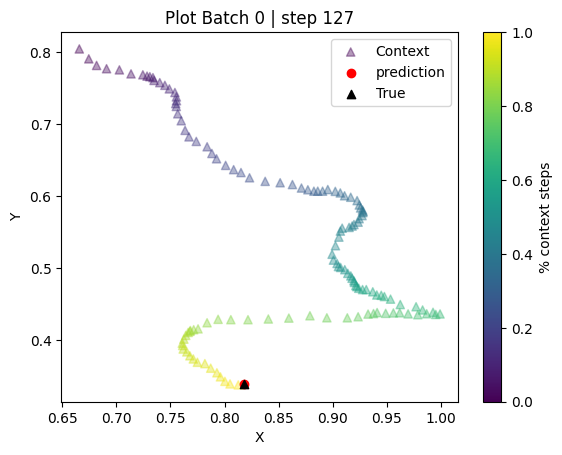

In [31]:
for i in range(120, CONTEXT_LEN):
    plt.title(f'Plot Batch 0 | step {i:03d}')
    plt.scatter(tx[0,0:i, 0], tx[0,0:i, 1],  label='Context', c=[color for color in range(len(tx[0,0:i, 0]))], alpha=0.4, marker='^')
    plt.scatter(model_prediction[0, i:i+1, 0], model_prediction[0, i:i+1, 1], label='prediction', c='r')
    plt.scatter(ty[0, i-1:i,0], ty[0, i-1:i,1], label='True', c='k', marker='^')
    plt.legend()
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.colorbar(label='% context steps')
    # plt.ylim(0, 1)
    # plt.xlim(0,1)
    # plt.savefig(f'/home/mgteus/workspace/neuro/transformers_andrej/plots/gifs/step{i:03d}_fix.png', format='png')
    # plt.close()

    plt.show()

In [95]:
import glob
import os
from PIL import Image


# filepaths

fp_in =  f'/home/mgteus/workspace/neuro/transformers_andrej/plots/gifs/**_fix.png'
fp_out =  f'/home/mgteus/workspace/neuro/transformers_andrej/plots/test_run_fix_20s.gif'

# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=200, loop=0)

In [38]:
print(model.blocks[0].sa.heads[0].key)

Linear(in_features=2, out_features=256, bias=False)


In [39]:
print(model.blocks[0].sa.linear_both.weight)

Parameter containing:
tensor([[-0.7859, -0.3735],
        [-0.0379, -0.3424]], device='cuda:0', requires_grad=True)


In [40]:
print(model.blocks[0].ffwd.layer[0])

Linear(in_features=2, out_features=8, bias=True)


In [34]:
model.to('cpu')

Transformers(
  (blocks): ModuleList(
    (0): TransformerBlock(
      (sa): MultiHeadAttention(
        (pose): PositionEncoding()
        (linear_both): Linear(in_features=2, out_features=2, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
        (heads): ModuleList(
          (0-1): 2 x Head(
            (enc_layer): Linear(in_features=2, out_features=1, bias=True)
            (output_layer): Linear(in_features=2, out_features=1, bias=False)
            (key): Linear(in_features=2, out_features=2, bias=False)
            (query): Linear(in_features=2, out_features=2, bias=False)
            (values): Linear(in_features=2, out_features=2, bias=False)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (ffwd): FeedForwardLayer(
        (layer): Sequential(
          (0): Linear(in_features=2, out_features=8, bias=True)
          (1): ReLU()
          (2): Linear(in_features=8, out_features=2, bias=True)
        )
      )
    )
  )
  (n

In [40]:
head0_key_weight = model.blocks[0].sa.heads[0].key.weight.detach().numpy()
head1_key_weight = model.blocks[0].sa.heads[1].key.weight.detach().numpy()

head0_query_weight = model.blocks[0].sa.heads[0].query.weight.detach().numpy()
head1_query_weight = model.blocks[0].sa.heads[1].query.weight.detach().numpy()


head0_values_weight = model.blocks[0].sa.heads[0].values.weight.detach().numpy()
head1_values_weight = model.blocks[0].sa.heads[1].values.weight.detach().numpy()


head0_output_lay_weight = model.blocks[0].sa.heads[0].output_layer.weight.detach().numpy()
head1_output_lay_weight = model.blocks[0].sa.heads[1].output_layer.weight.detach().numpy()
# query_weight = model.query.weight.detach().numpy()
# values_weight = model.values.weight.detach().numpy()

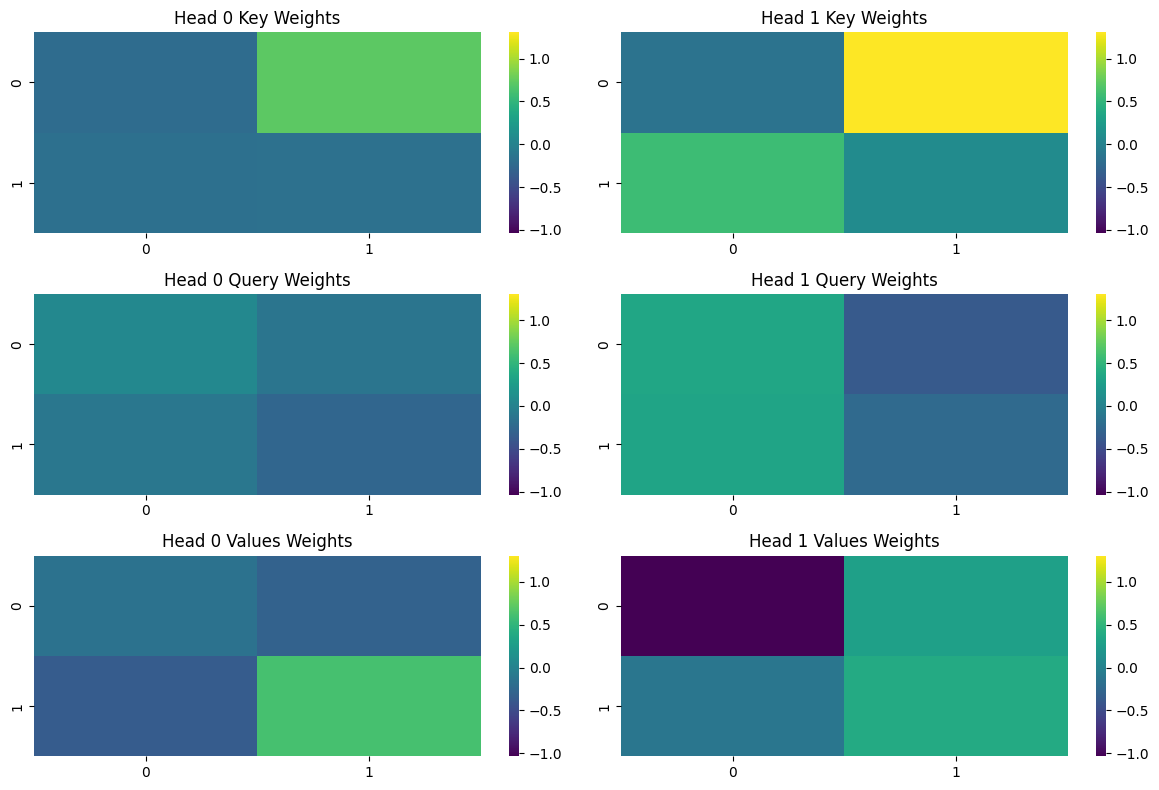

In [71]:
fig, ax = plt.subplots(3, 2, figsize=(12, 8))

vmin_ = np.min([np.min(head0_key_weight)
                , np.min(head1_key_weight)
                , np.min(head0_query_weight)
                , np.min(head1_query_weight)
                , np.min(head0_values_weight)
                , np.min(head1_values_weight) ])


vmax_ = np.max([np.max(head0_key_weight)
                , np.max(head1_key_weight)
                , np.max(head0_query_weight)
                , np.max(head1_query_weight)
                , np.max(head0_values_weight)
                , np.max(head1_values_weight) ])






sns.heatmap(head0_key_weight, cmap='viridis', ax=ax[0, 0], vmin=vmin_, vmax=vmax_)
ax[0,0].set_title('Head 0 Key Weights')

sns.heatmap(head1_key_weight, cmap='viridis', ax=ax[0, 1], vmin=vmin_, vmax=vmax_)
ax[0,1].set_title('Head 1 Key Weights')


sns.heatmap(head0_query_weight, cmap='viridis', ax=ax[1, 0], vmin=vmin_, vmax=vmax_)
ax[1, 0].set_title('Head 0 Query Weights')

sns.heatmap(head1_query_weight, cmap='viridis', ax=ax[1, 1], vmin=vmin_, vmax=vmax_)
ax[1, 1].set_title('Head 1 Query Weights')


sns.heatmap(head0_values_weight, cmap='viridis', ax=ax[2, 0], vmin=vmin_, vmax=vmax_)
ax[2, 0].set_title('Head 0 Values Weights')

sns.heatmap(head1_values_weight, cmap='viridis', ax=ax[2, 1], vmin=vmin_, vmax=vmax_)
ax[2, 1].set_title('Head 1 Values Weights')

# sns.heatmap(query_weight, cmap='viridis', ax=ax[1])
# ax[1].set_title('Query Weights')

# sns.heatmap(values_weight, cmap='viridis', ax=ax[2])
# ax[2].set_title('Values Weights')
plt.tight_layout()
plt.show()

In [37]:
ffwd_lin1_weigths = model.blocks[0].ffwd.layer[0].weight.detach().numpy()
ffwd_lin2_weigths = model.blocks[0].ffwd.layer[2].weight.detach().numpy()

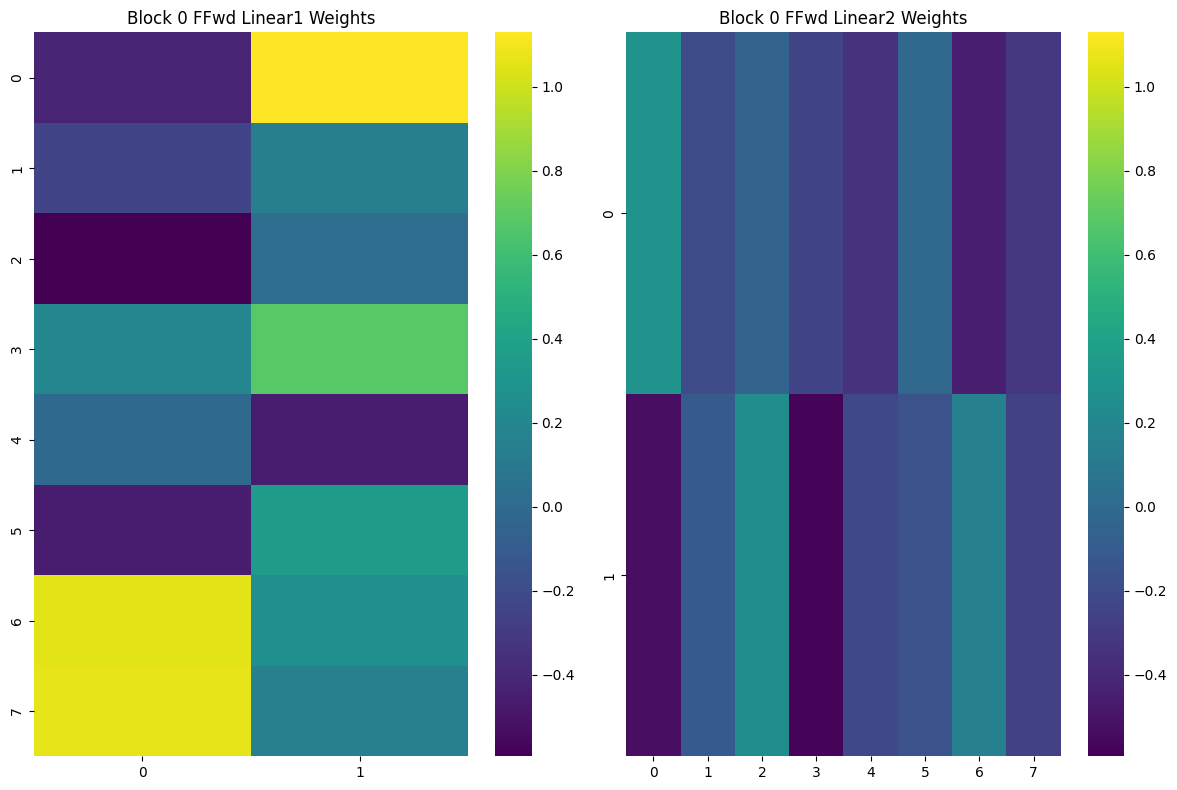

In [70]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

vmin_ = np.min([np.min(ffwd_lin1_weigths), np.min(ffwd_lin2_weigths)])
vmax_ = np.max([np.max(ffwd_lin1_weigths), np.max(ffwd_lin2_weigths)])

sns.heatmap(ffwd_lin1_weigths, cmap='viridis', ax=ax[0], vmin=vmin_, vmax=vmax_)
ax[0].set_title('Block 0 FFwd Linear1 Weights')

sns.heatmap(ffwd_lin2_weigths, cmap='viridis', ax=ax[1], vmin=vmin_, vmax=vmax_)
ax[1].set_title('Block 0 FFwd Linear2 Weights')


# sns.heatmap(query_weight, cmap='viridis', ax=ax[1])
# ax[1].set_title('Query Weights')

# sns.heatmap(values_weight, cmap='viridis', ax=ax[2])
# ax[2].set_title('Values Weights')
plt.tight_layout()
plt.show()

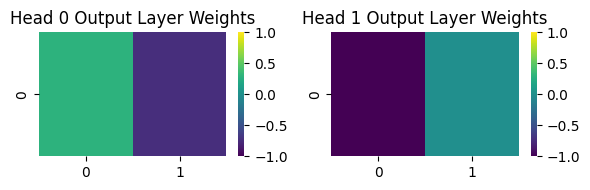

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(6, 2))




sns.heatmap(head0_output_lay_weight, cmap='viridis', ax=ax[0], vmin=-1, vmax=+1)
ax[0].set_title('Head 0 Output Layer Weights')

sns.heatmap(head1_output_lay_weight, cmap='viridis', ax=ax[1], vmin=-1, vmax=+1)
ax[1].set_title('Head 1 Output Layer Weights')


# sns.heatmap(query_weight, cmap='viridis', ax=ax[1])
# ax[1].set_title('Query Weights')

# sns.heatmap(values_weight, cmap='viridis', ax=ax[2])
# ax[2].set_title('Values Weights')
plt.tight_layout()
plt.show()

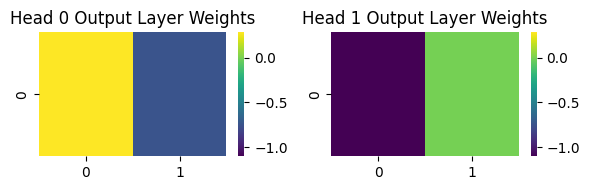

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(6, 2))

vmin_ = np.min([np.min(head0_output_lay_weight), np.min(head1_output_lay_weight)])
vmax_ = np.max([np.max(head0_output_lay_weight), np.max(head1_output_lay_weight)])


sns.heatmap(head0_output_lay_weight, cmap='viridis', ax=ax[0], vmin=vmin_, vmax=vmax_)
ax[0].set_title('Head 0 Output Layer Weights')

sns.heatmap(head1_output_lay_weight, cmap='viridis', ax=ax[1], vmin=vmin_, vmax=vmax_)
ax[1].set_title('Head 1 Output Layer Weights')


# sns.heatmap(query_weight, cmap='viridis', ax=ax[1])
# ax[1].set_title('Query Weights')

# sns.heatmap(values_weight, cmap='viridis', ax=ax[2])
# ax[2].set_title('Values Weights')
plt.tight_layout()
plt.show()

In [67]:
np.max(head1_output_lay_weight), np.min(head1_output_lay_weight)

(-0.008352596, -1.1028278)

In [49]:
model.to(DEVICE)

Transformers(
  (blocks): ModuleList(
    (0): TransformerBlock(
      (sa): MultiHeadAttention(
        (pose): PositionEncoding()
        (linear_both): Linear(in_features=2, out_features=2, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
        (heads): ModuleList(
          (0-1): 2 x Head(
            (enc_layer): Linear(in_features=2, out_features=1, bias=True)
            (output_layer): Linear(in_features=2, out_features=1, bias=False)
            (key): Linear(in_features=2, out_features=2, bias=False)
            (query): Linear(in_features=2, out_features=2, bias=False)
            (values): Linear(in_features=2, out_features=2, bias=False)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (ffwd): FeedForwardLayer(
        (layer): Sequential(
          (0): Linear(in_features=2, out_features=8, bias=True)
          (1): ReLU()
          (2): Linear(in_features=8, out_features=2, bias=True)
        )
      )
    )
  )
  (n

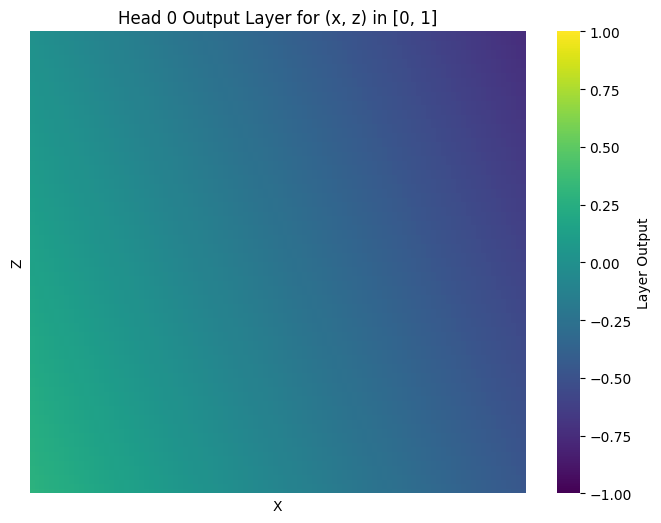

In [63]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Configuração da camada linear
input_dim = 2  # Dois inputs: x e y
output_dim = 1  # Saída escalar
# layer = torch.nn.Linear(input_dim, output_dim)

# Criando uma grade de valores (x, y) no intervalo [0, 1]
x_values = torch.linspace(0, 1, 100)  # 100 pontos no intervalo [0, 1]
y_values = torch.linspace(0, 1, 100)
x_grid, y_grid = torch.meshgrid(x_values, y_values, indexing='ij')  # Grade 2D
x_grid = x_grid.to(DEVICE)
y_grid = y_grid.to(DEVICE)
# Preparando os dados para análise
inputs = torch.stack([x_grid.flatten(), y_grid.flatten()], dim=1)  # Combinação de pares (x, y)

# Passando pela camada linear
outputs = model.blocks[0].sa.heads[0].output_layer(inputs).cpu().detach().numpy().reshape(100, 100)  # Resultado reshape para a grade

# Visualizando com um heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(outputs, cmap='viridis', xticklabels=False, yticklabels=False, cbar_kws={'label': 'Layer Output'}, vmin=-1, vmax=1)
plt.title("Head 0 Output Layer for (x, z) in [0, 1]")
plt.xlabel("X")
plt.ylabel("Z")
plt.show()


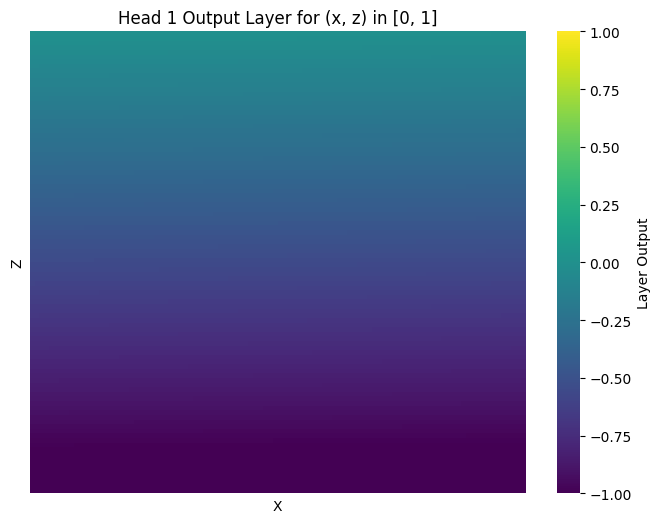

In [64]:
# Configuração da camada linear
input_dim = 2  # Dois inputs: x e y
output_dim = 1  # Saída escalar
# layer = torch.nn.Linear(input_dim, output_dim)

# Criando uma grade de valores (x, y) no intervalo [0, 1]
x_values = torch.linspace(0, 1, 100)  # 100 pontos no intervalo [0, 1]
y_values = torch.linspace(0, 1, 100)
x_grid, y_grid = torch.meshgrid(x_values, y_values, indexing='ij')  # Grade 2D
x_grid = x_grid.to(DEVICE)
y_grid = y_grid.to(DEVICE)
# Preparando os dados para análise
inputs = torch.stack([x_grid.flatten(), y_grid.flatten()], dim=1)  # Combinação de pares (x, y)

# Passando pela camada linear
outputs = model.blocks[0].sa.heads[1].output_layer(inputs).cpu().detach().numpy().reshape(100, 100)  # Resultado reshape para a grade

# Visualizando com um heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(outputs, cmap='viridis', xticklabels=False, yticklabels=False, cbar_kws={'label': 'Layer Output'}, vmin=-1, vmax=1)
plt.title("Head 1 Output Layer for (x, z) in [0, 1]")
plt.xlabel("X")
plt.ylabel("Z",)
plt.show()


In [72]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Configuração da camada linear
input_dim = 2  # Dois inputs: x e y
output_dim = 1  # Saída escalar
# layer = torch.nn.Linear(input_dim, output_dim)

# Criando uma grade de valores (x, y) no intervalo [0, 1]
x_values = torch.linspace(0, 1, 100)  # 100 pontos no intervalo [0, 1]
y_values = torch.linspace(0, 1, 100)
x_grid, y_grid = torch.meshgrid(x_values, y_values, indexing='ij')  # Grade 2D
x_grid = x_grid.to(DEVICE)
y_grid = y_grid.to(DEVICE)
# Preparando os dados para análise
inputs = torch.stack([x_grid.flatten(), y_grid.flatten()], dim=1)  # Combinação de pares (x, y)

# Passando pela camada linear
outputs = model.blocks[0].sa.heads[0].key(inputs).cpu().detach().numpy().reshape(100, 100)  # Resultado reshape para a grade

# Visualizando com um heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(outputs, cmap='viridis', xticklabels=False, yticklabels=False, cbar_kws={'label': 'Layer Output'}, vmin=-1, vmax=1)
plt.title("Head 0 Output Layer for (x, z) in [0, 1]")
plt.xlabel("X")
plt.ylabel("Z")
plt.show()


ValueError: cannot reshape array of size 20000 into shape (100,100)

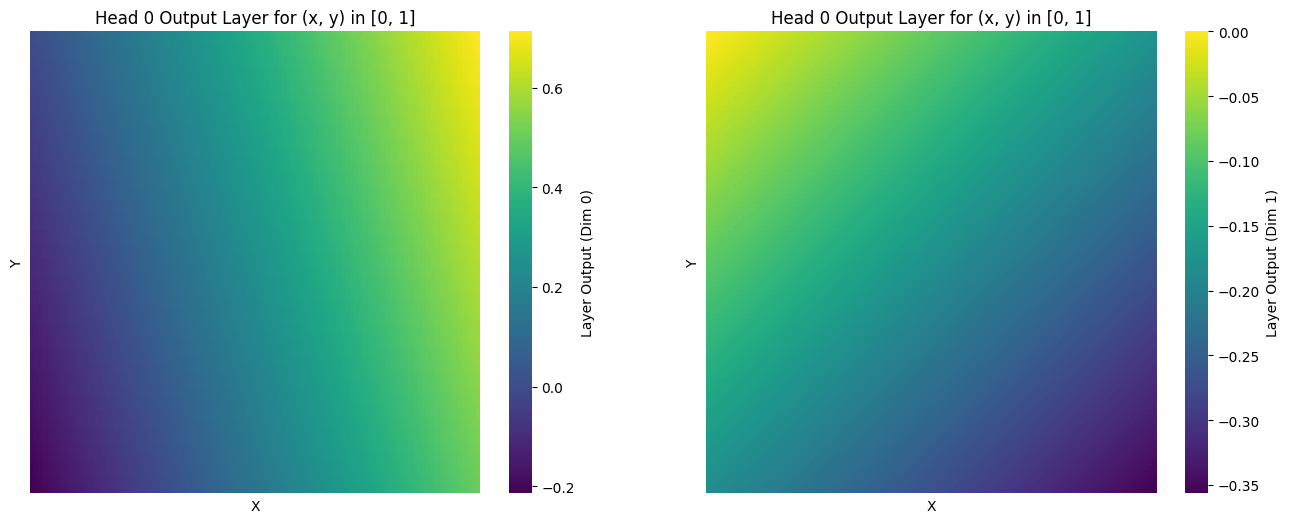

In [76]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Device setup
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Configure the model layer (use your actual model's layer)
# Assuming `model.blocks[0].sa.heads[0].key` produces a 2D output

# Configuration of inputs
input_dim = 2  # Two inputs: x and y
output_dim = 2  # Assume 2D output
x_values = torch.linspace(0, 1, 100)  # 100 points in range [0, 1]
y_values = torch.linspace(0, 1, 100)

# Creating a grid of values (x, y)
x_grid, y_grid = torch.meshgrid(x_values, y_values, indexing='ij')
x_grid = x_grid.to(DEVICE)
y_grid = y_grid.to(DEVICE)

# Preparing the input pairs
inputs = torch.stack([x_grid.flatten(), y_grid.flatten()], dim=1)

# Pass through the model layer and reshape output
outputs = model.blocks[0].sa.heads[0].key(inputs)  # Assuming shape (10000, 2)
outputs = outputs.cpu().detach().numpy()  # Convert to NumPy
outputs_reshaped = outputs.reshape(100, 100, -1)  # Reshape to 3D (100x100x2)

# Select one of the output dimensions for visualization (e.g., the first dimension)
output_to_plot_dim0 = outputs_reshaped[:, :, 0]  # Visualize the first output dimension
output_to_plot_dim1 = outputs_reshaped[:, :, 1]
# Plot the heatmap
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.heatmap(
    output_to_plot_dim0,
    cmap='viridis',
    xticklabels=False,
    yticklabels=False,
    cbar_kws={'label': 'Layer Output (Dim 0)'},ax=ax[0]
)
ax[0].set_title("Head 0 Output Layer for (x, y) in [0, 1]")
ax[0].set_xlabel("X")
ax[0].set_ylabel("Y")


sns.heatmap(
    output_to_plot_dim1,
    cmap='viridis',
    xticklabels=False,
    yticklabels=False,
    cbar_kws={'label': 'Layer Output (Dim 1)'},ax=ax[1]
)
ax[1].set_title("Head 0 Output Layer for (x, y) in [0, 1]")
ax[1].set_xlabel("X")
ax[1].set_ylabel("Y")
plt.show()


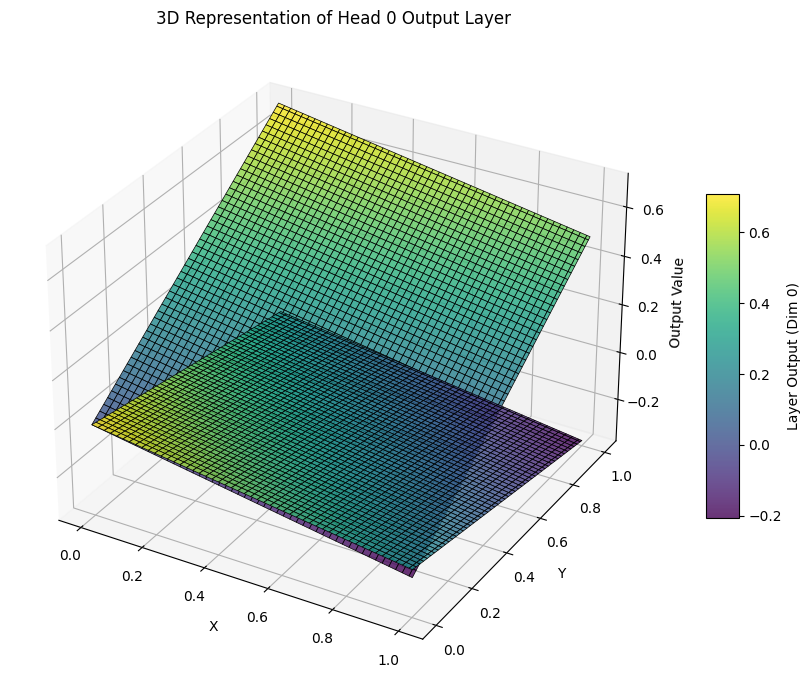

In [78]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Device setup
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Configuration of inputs
x_values = torch.linspace(0, 1, 100)  # 100 points in range [0, 1]
y_values = torch.linspace(0, 1, 100)

# Creating a grid of values (x, y)
x_grid, y_grid = torch.meshgrid(x_values, y_values, indexing='ij')
x_grid = x_grid.to(DEVICE)
y_grid = y_grid.to(DEVICE)

# Preparing the input pairs
inputs = torch.stack([x_grid.flatten(), y_grid.flatten()], dim=1)

# Pass through the model layer and reshape output
outputs = model.blocks[0].sa.heads[0].key(inputs)  # Assuming shape (10000, 2)
outputs = outputs.cpu().detach().numpy()  # Convert to NumPy
outputs_reshaped = outputs.reshape(100, 100, -1)  # Reshape to 3D (100x100x2)

# Select one of the output dimensions for visualization (e.g., the first dimension)
output_to_plot_dim0 = outputs_reshaped[:, :, 0]  # Visualize the first output dimension
output_to_plot_dim1 = outputs_reshaped[:, :, 1]  # Visualize the first output dimension
# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf1 = ax.plot_surface(
    x_grid.cpu().numpy(),
    y_grid.cpu().numpy(),
    output_to_plot_dim0,
    cmap='viridis',
    edgecolor='k',
    linewidth=0.5,
    alpha=0.8
)
surf2 = ax.plot_surface(
    x_grid.cpu().numpy(),
    y_grid.cpu().numpy(),
    output_to_plot_dim1,
    cmap='viridis',
    edgecolor='k',
    linewidth=0.5,
    alpha=0.8
)

# Add a color bar and labels
fig.colorbar(surf1, ax=ax, shrink=0.5, aspect=10, label="Layer Output (Dim 0)")
ax.set_title("3D Representation of Head 0 Output Layer")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Output Value")
plt.tight_layout()
plt.show()


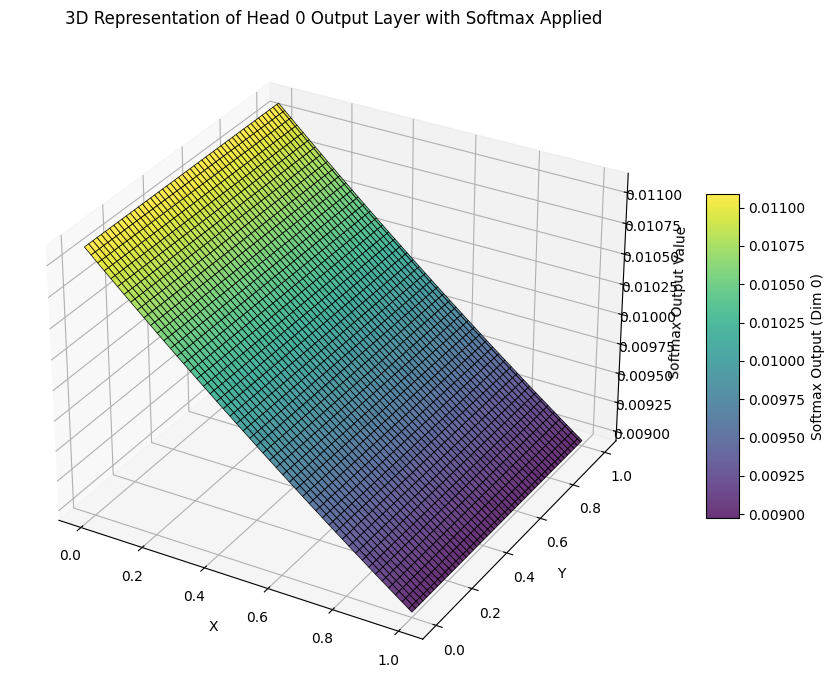

In [79]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch.nn.functional as F

# Device setup
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Configuration of inputs
x_values = torch.linspace(0, 1, 100)  # 100 points in range [0, 1]
y_values = torch.linspace(0, 1, 100)

# Creating a grid of values (x, y)
x_grid, y_grid = torch.meshgrid(x_values, y_values, indexing='ij')
x_grid = x_grid.to(DEVICE)
y_grid = y_grid.to(DEVICE)

# Preparing the input pairs
inputs = torch.stack([x_grid.flatten(), y_grid.flatten()], dim=1)

# Pass through the model layer and reshape output
outputs = model.blocks[0].sa.heads[0].key(inputs)  # Assuming shape (10000, 2)
outputs = outputs.cpu().detach().numpy()  # Convert to NumPy
outputs_reshaped = outputs.reshape(100, 100, -1)  # Reshape to 3D (100x100x2)

# Select one of the output dimensions for visualization (e.g., the first dimension)
output_to_plot = outputs_reshaped[:, :, 0]  # Visualize the first output dimension

# Apply softmax to the output
output_to_plot_tensor = torch.tensor(output_to_plot)  # Convert to PyTorch tensor
softmax_output = F.softmax(output_to_plot_tensor, dim=0)  # Apply softmax along one axis
softmax_output_np = softmax_output.numpy()  # Convert back to NumPy for plotting

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(
    x_grid.cpu().numpy(),
    y_grid.cpu().numpy(),
    softmax_output_np,
    cmap='viridis',
    edgecolor='k',
    linewidth=0.5,
    alpha=0.8
)

# Add a color bar and labels
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label="Softmax Output (Dim 0)")
ax.set_title("3D Representation of Head 0 Output Layer with Softmax Applied")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Softmax Output Value")
plt.tight_layout()
plt.show()
